In [1]:
# StopWord List

import json

# --- Load Stop Words ---
stop_words_file = "data/stop_words_arabic.txt"  # Replace with your actual path
with open(stop_words_file, "r", encoding="utf-8") as file:
    stop_words = set(word.strip() for word in file if word.strip())

# --- Load Normalized Unified Quran Data ---
input_file = "data/normalized_unified_quran_data.json"
with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

# --- Function to Filter Stopwords from Roots ---
def filter_stopwords_in_roots(data, stop_words):
    """
    For each verse, filters out stop words from the 'arabic_roots' field.
    Adds two new keys:
      - 'filtered_roots': roots that are not stopwords.
      - 'filtered_out_roots': roots that were filtered out.
    """
    filtered_data = []
    for verse in data:
        # Retrieve roots; default to an empty list if missing
        roots = verse.get("arabic_roots", [])
        filtered_roots = [root for root in roots if root not in stop_words]
        filtered_out = [root for root in roots if root in stop_words]
        verse["filtered_roots"] = filtered_roots
        verse["filtered_out_roots"] = filtered_out
        filtered_data.append(verse)
    return filtered_data

# --- Apply Stopword Filtering ---
filtered_data = filter_stopwords_in_roots(normalized_data, stop_words)

# --- Save the Filtered Data ---
output_file = "data/filtered_unified_quran_data.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(filtered_data, f, ensure_ascii=False, indent=4)

print("✅ Filtered data saved to:", output_file)


✅ Filtered data saved to: data/filtered_unified_quran_data.json


In [7]:
# Dynamic Sequential Window Generation & Root Extaction

import json
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast

# === Ask for user inputs ===
multiplier = float(input("Enter multiplier for threshold computation (e.g., 0.1): "))
min_window_size = int(input("Enter minimum window size (number of verses): "))
max_window_size = int(input("Enter maximum window size (number of verses): "))

# === Parameters ===
custom_threshold = None  # Set a custom threshold to override computed thresholds (None to compute adaptively)

# === Load filtered JSON data (retaining original text) ===
with open("data/filtered_unified_quran_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

json_df = pd.DataFrame(data)
json_df["surah"] = json_df["surah"].astype(int)
json_df["verse"] = json_df["verse"].astype(int)
json_df = json_df.sort_values(["surah", "verse"]).reset_index(drop=True)

# === Build mapped document using filtered tokens ===
def build_document(record):
    if (
        "normalized_tokens" in record and 
        "arabic_roots" in record and 
        "filtered_roots" in record and
        isinstance(record["normalized_tokens"], list) and 
        isinstance(record["arabic_roots"], list) and
        isinstance(record["filtered_roots"], list)
    ):
        normalized = record["normalized_tokens"]
        roots = record["arabic_roots"]
        filtered = record["filtered_roots"]
        if len(normalized) == len(roots):
            tokens = [normalized[i] for i in range(len(normalized)) if roots[i] in filtered]
            return " ".join(tokens).strip()
        else:
            return " ".join(normalized).strip()
    return ""

json_df["mapped_document"] = json_df.apply(lambda row: build_document(row), axis=1)
json_df = json_df[json_df["mapped_document"].str.strip().astype(bool)].copy()

# === Load embeddings ===
embeddings_df = pd.read_pickle("data/quran_sentence_AraBERT_embeddings.pkl")
embeddings_df["surah"] = embeddings_df["surah"].astype(int)
embeddings_df["verse"] = embeddings_df["verse"].astype(int)

# === Merge and prepare ===
merged_df = pd.merge(json_df, embeddings_df[['surah', 'verse', 'embedding']], 
                     on=["surah", "verse"], how="inner")
merged_df = merged_df.sort_values(["surah", "verse"]).reset_index(drop=True)

# (Optional) Convert "arabic_roots" from string to list if necessary
if merged_df["arabic_roots"].dtype == object:
    def parse_roots(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        return x
    merged_df["arabic_roots"] = merged_df["arabic_roots"].apply(parse_roots)

# Save merged DataFrame as CSV for future use
merged_df.to_csv("data/merged_quran_data.csv", index=False)
print("Merged data saved to data/merged_quran_data.csv")

docs = merged_df["mapped_document"].tolist()
original_texts = merged_df["text"].tolist()
surahs = merged_df["surah"].tolist()
verses = merged_df["verse"].tolist()
embeddings = np.array(merged_df["embedding"].tolist())

# === Hierarchical / Adaptive Segmentation per Surah ===
adaptive_windows = []       # To store concatenated window texts (for reference)
adaptive_window_info = []   # To store window details: list of tuples (surah, verse, original text)

# Group verses by surah (coarse segmentation)
grouped = merged_df.groupby("surah", sort=True)
for surah, group in grouped:
    group = group.sort_values("verse").reset_index(drop=True)
    docs_group = group["mapped_document"].tolist()
    original_group = group["text"].tolist()
    verses_group = group["verse"].tolist()
    surah_list = group["surah"].tolist()  # all same surah
    embeddings_group = np.array(group["embedding"].tolist())
    
    # Compute cosine similarity between consecutive verse embeddings in this surah
    cos_sims_group = []
    for i in range(len(embeddings_group) - 1):
        sim = cosine_similarity(embeddings_group[i].reshape(1, -1), embeddings_group[i+1].reshape(1, -1))[0, 0]
        cos_sims_group.append(sim)
    
    # Compute local threshold for this surah
    if len(cos_sims_group) > 0:
        computed_threshold = np.mean(cos_sims_group) - multiplier * np.std(cos_sims_group)
        local_threshold = custom_threshold if custom_threshold is not None else computed_threshold
    else:
        local_threshold = custom_threshold if custom_threshold is not None else 0.85
    
    print(f"Surah {surah}: Using threshold {local_threshold:.4f} based on {len(cos_sims_group)} similarities.")
    
    # Segment the verses in this surah based on the local threshold
    local_windows_indices = []
    current_window_indices = [0]
    for i in range(len(cos_sims_group)):
        if cos_sims_group[i] >= local_threshold:
            current_window_indices.append(i+1)
        else:
            local_windows_indices.append(current_window_indices)
            # Optionally, allow overlap: start new window with last index
            current_window_indices = [current_window_indices[-1]]
    if current_window_indices:
        local_windows_indices.append(current_window_indices)
    
    # Append windows from this surah to the overall list
    for indices in local_windows_indices:
        window_text = " ".join([docs_group[i] for i in indices])
        window_details = [(surah_list[i], verses_group[i], original_group[i]) for i in indices]
        adaptive_windows.append(window_text)
        adaptive_window_info.append(window_details)

print(f"✅ Adaptive segmentation produced {len(adaptive_windows)} windows in total.")

# === Post-Processing: Enforce Window Size Constraints with Duplicate Removal ===
merged_windows_info = []
temp_window = []

for window in adaptive_window_info:
    if not temp_window:
        temp_window = window.copy()
    else:
        if len(temp_window) < min_window_size:
            # Check if the last verse of temp_window is the same as the first verse of window (by surah and verse)
            if temp_window[-1][:2] == window[0][:2]:
                temp_window.extend(window[1:])  # Skip duplicate
            else:
                temp_window.extend(window)
        else:
            merged_windows_info.append(temp_window)
            temp_window = window.copy()
if temp_window:
    merged_windows_info.append(temp_window)

# Split any window that exceeds max_window_size into smaller windows.
final_windows_info = []
for window in merged_windows_info:
    if len(window) > max_window_size:
        for i in range(0, len(window), max_window_size):
            chunk = window[i:i+max_window_size]
            final_windows_info.append(chunk)
    else:
        final_windows_info.append(window)

print(f"Post-processing produced {len(final_windows_info)} final windows after merging/splitting.")

# Save final windows info as a pickle file for future use
with open("data/Sequential_final_windows_info.pkl", "wb") as f:
    pickle.dump(final_windows_info, f)
print("Final windows info saved to data/Sequential_final_windows_info.pkl")

# === Compute Unique Roots for Each Final Window ===
final_windows_roots = []  # List to store set of unique roots for each window

for window in final_windows_info:
    roots_set = set()
    # For each verse in the window (each is a tuple: (surah, verse, original text))
    for surah, verse, _ in window:
        row = merged_df[(merged_df["surah"] == surah) & (merged_df["verse"] == verse)]
        if not row.empty:
            verse_roots = row.iloc[0].get("arabic_roots", [])
            if isinstance(verse_roots, str):
                try:
                    verse_roots = ast.literal_eval(verse_roots)
                except Exception:
                    verse_roots = []
            if isinstance(verse_roots, list):
                roots_set.update(verse_roots)
    final_windows_roots.append(roots_set)

# === Save Final Windows with Their Unique Roots to .txt ===
output_path_final = "data/quran_Sequential_final_windows.txt"
with open(output_path_final, "w", encoding="utf-8") as f:
    for idx, window in enumerate(final_windows_info):
        f.write("="*40 + "\n")
        unique_roots = sorted(final_windows_roots[idx])
        f.write(f"🪟 Final Window {idx+1} (Total Verses: {len(window)})\n")
        f.write("Unique Roots: " + ", ".join(unique_roots) + "\n\n")
        for surah, verse, text in window:
            f.write(f"({surah}:{verse}) {text}\n")
        f.write("\n")

print(f"📄 Final windows with unique roots saved to: {output_path_final}")


KeyboardInterrupt: Interrupted by user

In [5]:
# Root Configuration
specific_root = "صلح"

In [15]:
# Extract Root Sequential Windows

import pickle
import pandas as pd
import ast

# === Load final window info ===
with open("data/Sequential_final_windows_info.pkl", "rb") as f:
    final_windows_info = pickle.load(f)

# === Load merged data to reconstruct filtered roots per window ===
merged_df = pd.read_csv("data/merged_quran_data.csv")

# Convert 'filtered_roots' from string to list if needed
def parse_filtered_roots(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

merged_df["filtered_roots"] = merged_df["filtered_roots"].apply(parse_filtered_roots)

# === Rebuild final_windows_roots using filtered_roots ===
final_windows_roots = []
for window in final_windows_info:
    roots_set = set()
    for surah, verse, _ in window:
        row = merged_df[(merged_df["surah"] == surah) & (merged_df["verse"] == verse)]
        if not row.empty:
            roots = row.iloc[0]["filtered_roots"]
            roots_set.update(roots)
    final_windows_roots.append(roots_set)

# === Extract windows containing specific root ===
specific_root = "صلح"  # 🔁 Change this root as needed
windows_with_specific_root = [
    idx for idx, roots in enumerate(final_windows_roots) if specific_root in roots
]

print(f"✅ Found {len(windows_with_specific_root)} final windows containing root '{specific_root}'.")

# === Save matching windows to a .txt file ===
output_file = f"output/{specific_root}_Sequential_windows.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for idx in windows_with_specific_root:
        window = final_windows_info[idx]
        unique_roots = sorted(final_windows_roots[idx])
        total_verses = len(window)
        f.write("="*40 + "\n")
        f.write(f"🪟 Final Window {idx+1} (Total Verses: {total_verses}, contains root: {specific_root})\n")
        f.write("Unique Roots: " + ", ".join(unique_roots) + "\n\n")
        for surah, verse, text in window:
            f.write(f"({surah}:{verse}) {text}\n")
        f.write("\n")

print(f"📄 Saved final windows with root '{specific_root}' to: {output_file}")


✅ Found 127 final windows containing root 'صلح'.
📄 Saved final windows with root 'صلح' to: output/صلح_Sequential_windows.txt


In [16]:
# Root Co-occurrence in Window


import pandas as pd
import pickle
import ast


# === Load merged data with filtered roots ===
merged_df = pd.read_csv("data/merged_quran_data.csv")

# Convert filtered_roots column from string to list
merged_df["filtered_roots"] = merged_df["filtered_roots"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# === Load saved window info ===
with open("data/Sequential_final_windows_info.pkl", "rb") as f:
    final_windows_info = pickle.load(f)

# === Compute window-level co-occurrence of filtered roots ===
cooc_counts = {}

for window in final_windows_info:
    window_filtered_roots = set()
    for surah, verse, _ in window:
        row = merged_df[(merged_df["surah"] == surah) & (merged_df["verse"] == verse)]
        if not row.empty:
            roots = row.iloc[0]["filtered_roots"]
            if isinstance(roots, list):
                window_filtered_roots.update(roots)
    if specific_root in window_filtered_roots:
        for r in window_filtered_roots:
            if r != specific_root:
                cooc_counts[r] = cooc_counts.get(r, 0) + 1

# === Sort and Save Co-occurrence Output ===
sorted_cooc = sorted(cooc_counts.items(), key=lambda x: x[1], reverse=True)

output_file = f"output/{specific_root}_global_cooccurrence_filtered.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(f"Global window-level co-occurrence counts of filtered roots with '{specific_root}':\n\n")
    for root, count in sorted_cooc:
        f.write(f"{root}: {count}\n")

print(f"📄 Global window-level co-occurrence (filtered roots) saved to: {output_file}")


📄 Global window-level co-occurrence (filtered roots) saved to: output/صلح_global_cooccurrence_filtered.txt


C:\Users\DiQz\AppData\Local\Temp\ipykernel_18272\721076770.py:66: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



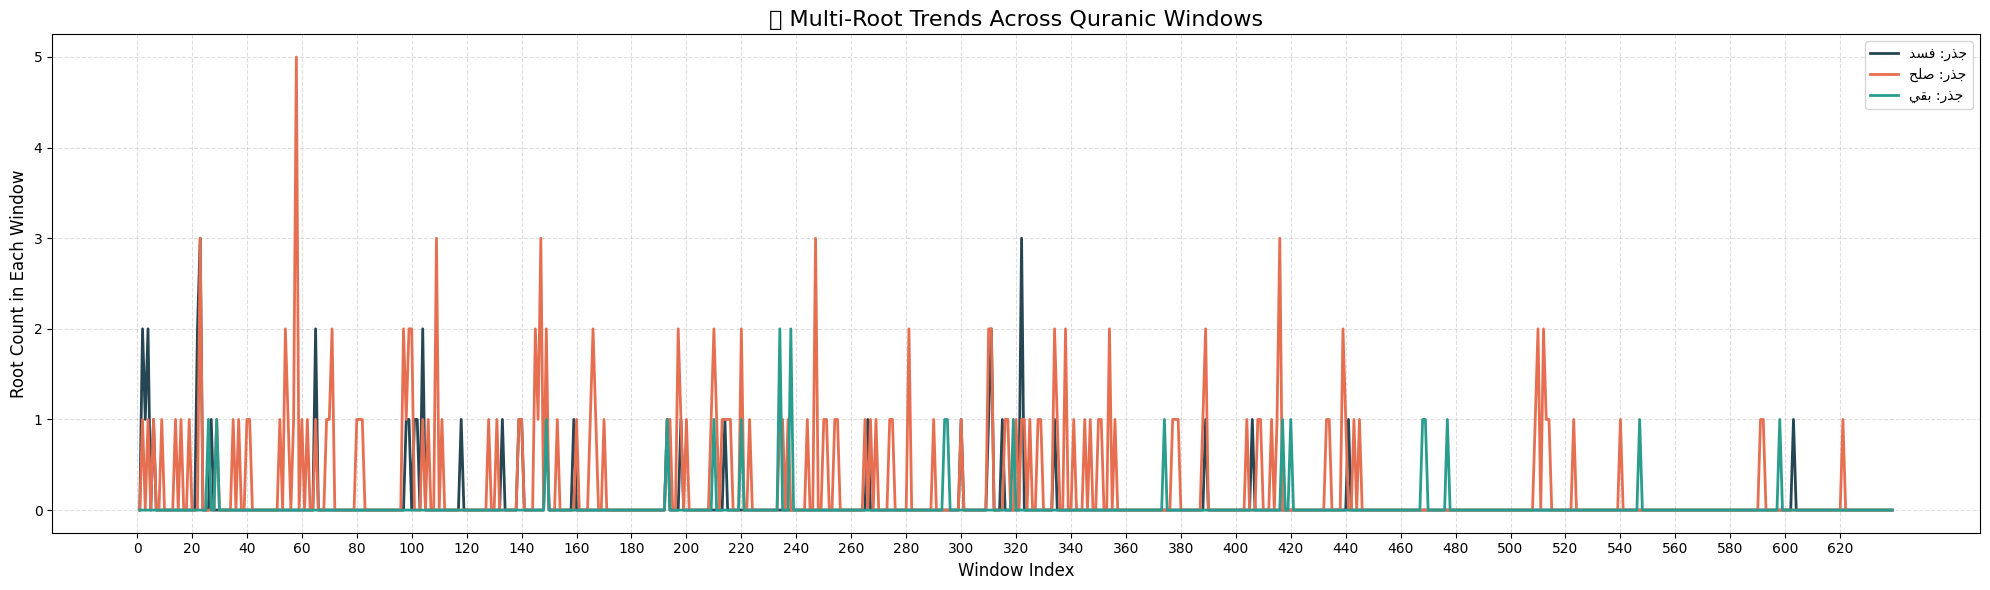

In [22]:
# Word Trend Graph

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ast
import arabic_reshaper
from bidi.algorithm import get_display

# === Helper to reshape Arabic for display ===
def reshape_arabic(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

# === Load merged DataFrame from CSV ===
merged_df = pd.read_csv("data/merged_quran_data.csv")

# Convert filtered_roots to list if needed
merged_df["filtered_roots"] = merged_df["filtered_roots"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# === Load window info ===
with open("data/Sequential_final_windows_info.pkl", "rb") as f:
    final_windows_info = pickle.load(f)

# === Define Arabic roots to track ===
roots_to_track = ["فسد", "صلح", "بقي"]  # Add or change roots as needed

# === Prepare trend data for each root ===
root_trends = {root: [] for root in roots_to_track}

for window in final_windows_info:
    for root in roots_to_track:
        total_count = 0
        for surah, verse, _ in window:
            row = merged_df[(merged_df["surah"] == surah) & (merged_df["verse"] == verse)]
            if not row.empty:
                roots = row.iloc[0]["filtered_roots"]
                if isinstance(roots, list):
                    total_count += roots.count(root)
        root_trends[root].append(total_count)

# === Window indices ===
window_indices = np.arange(1, len(final_windows_info) + 1)

# === Plotting ===
plt.figure(figsize=(20, 6))
colors = ["#264653", "#e76f51", "#2a9d8f", "#8a4fff", "#f4a261", "#f72585"]  # Extend as needed

for idx, root in enumerate(roots_to_track):
    trend = root_trends[root]
    color = colors[idx % len(colors)]
    label = reshape_arabic(f"جذر: {root}")
    plt.plot(window_indices, trend, label=label, color=color, linewidth=2, alpha=1)
    plt.scatter(window_indices, trend, color=color, s=0)

# === Styling ===
plt.title("📈 Multi-Root Trends Across Quranic Windows", fontsize=16)
plt.xlabel("Window Index", fontsize=12)
plt.ylabel("Root Count in Each Window", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(window_indices if len(window_indices) < 30 else np.arange(0, len(window_indices), 20))
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Bigram Comparison Roots

import pandas as pd
import numpy as np
import plotly.express as px
import ast
import pickle
import webbrowser
import plotly.io as pio

pio.renderers.default = "browser"  # or "jupyterlab"

# === Load saved final windows ===
with open("data/Sequential_final_windows_info.pkl", "rb") as f:
    final_windows_info = pickle.load(f)

# === Load merged_df from CSV ===
merged_df = pd.read_csv("data/merged_quran_data.csv")

# Ensure 'filtered_roots' column is a list
merged_df["filtered_roots"] = merged_df["filtered_roots"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# === Define roots to compare ===
root_1 = 'صلح'
root_2 = 'بقي'
roots_to_compare = [root_1, root_2]

# === Collect counts and bar widths per window ===
root1_counts, root2_counts, window_widths = [], [], []

for window in final_windows_info:
    count_r1, count_r2 = 0, 0
    window_widths.append(len(window))  # Bar width = number of verses
    for surah, verse, _ in window:
        row = merged_df[(merged_df["surah"] == surah) & (merged_df["verse"] == verse)]
        if not row.empty:
            roots = row.iloc[0]["filtered_roots"]
            if isinstance(roots, list):
                count_r1 += roots.count(root_1)
                count_r2 += roots.count(root_2)
    root1_counts.append(count_r1)
    root2_counts.append(-count_r2)  # Negate for mirrored bars

# === Build DataFrame for Plotly ===
window_indices = np.arange(1, len(final_windows_info) + 1)
df_bigrams = pd.DataFrame({
    "Window": np.tile(window_indices, 2),
    "Count": np.concatenate([root1_counts, root2_counts]),
    "Root": [root_1] * len(window_indices) + [root_2] * len(window_indices),
    "BarWidth": np.tile(window_widths, 2)
})

# === Plot with Plotly ===
fig = px.bar(
    df_bigrams,
    x="Window",
    y="Count",
    color="Root",
    title=f"Root Distribution by Window: {root_1} ↑ vs {root_2} ↓",
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Bold,
    opacity=0.9
)

fig.update_layout(
    width=3000,        # wider canvas = thicker bars
    height=600,
    bargap=0.03,       # less gap between windows
    bargroupgap=0.02,  # tighter grouping of mirrored roots
    legend_orientation="h",
    legend=dict(x=0.3, y=1.1),
    xaxis=dict(
        title="Window Index",
        tickmode="linear",
        dtick=10        # Label every 10th window
    ),
    yaxis=dict(
        title="Root Occurrence (↑ for one root, ↓ for other)"
    ),
    margin=dict(l=40, r=40, t=80, b=40)
)

# === Save & View ===
html_file = f"output/{safe_root1}_{safe_root2}_mirrored_root_distribution_comparison.html"
fig.write_html(html_file)
webbrowser.open_new_tab(html_file)
print(f"✅ Opened in browser: {html_file}")

# === Save PNG ===
safe_root1 = root_1.replace(" ", "_")
safe_root2 = root_2.replace(" ", "_")
png_file = f"output/{safe_root1}_{safe_root2}_mirrored_distribution.png"
pio.write_image(fig, png_file, width=2000, height=600, scale=2)
print(f"🖼️ PNG saved: {png_file}")

✅ Opened in browser: output/صلح_بقي_mirrored_root_distribution_comparison.html
🖼️ PNG saved: output/صلح_بقي_mirrored_distribution.png
